<a href="https://colab.research.google.com/github/abahl9/Gen_Deep_Learning_PyTorch/blob/main/CNN_Deep_Gen_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recreates final model in Chapter 2 of "Generative Deep Learning" by Foster

# Get CIFAR-10 data

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./Data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./Data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./Data/cifar-10-python.tar.gz to ./Data
Files already downloaded and verified


# Visualize an image

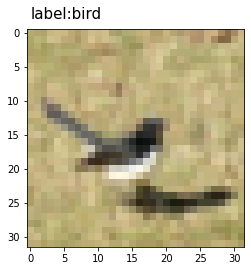

In [58]:
import matplotlib.pyplot as plt
import numpy as np


def my_imshow(img, label, prediction=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.text(0, -2, f'label:{label}', fontsize=15)
    if prediction: 
      plt.text(20, -2, f'pred:{prediction}', fontsize=15)
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)
idx = 0
my_imshow(images[idx], classes[labels[idx]])


# Model architecture

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class my_CNN(nn.Module):
    def __init__(self, in_channels, conv_channels, conv_filters, 
                 conv_strides, dense_units):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                               out_channels=conv_channels[0], 
                               kernel_size=conv_filters[0], stride=conv_strides[0], 
                               padding='same')
        self.batch_norm1 = nn.BatchNorm2d(num_features=conv_channels[0])
        self.conv2 = nn.Conv2d(in_channels=conv_channels[0], 
                               out_channels=conv_channels[1], 
                               kernel_size=conv_filters[1], stride=conv_strides[1], 
                               padding=1)
        self.batch_norm2 = nn.BatchNorm2d(num_features=conv_channels[1])        
        self.conv3 = nn.Conv2d(in_channels=conv_channels[1], 
                               out_channels=conv_channels[2], 
                               kernel_size=conv_filters[2], stride=conv_strides[2], 
                               padding='same')
        self.batch_norm3 = nn.BatchNorm2d(num_features=conv_channels[2])   
        self.conv4 = nn.Conv2d(in_channels=conv_channels[2], 
                               out_channels=conv_channels[3], 
                               kernel_size=conv_filters[3], stride=conv_strides[3], 
                               padding=1)
        self.batch_norm4 = nn.BatchNorm2d(num_features=conv_channels[3])

        self.dense1 = nn.Linear(in_features=4096, out_features=dense_units[0], bias=True)     
        self.batch_norm5 = nn.BatchNorm1d(num_features=dense_units[0])

        self.dense2 = nn.Linear(in_features=dense_units[0], out_features=dense_units[1], 
                                bias=True) 
        self.flatten1 = nn.Flatten()
        self.dropout1 = nn.Dropout(p=0.5)


    def forward(self, x):
        x = F.leaky_relu(self.batch_norm1(self.conv1(x)))
        x = F.leaky_relu(self.batch_norm2(self.conv2(x)))
        x = F.leaky_relu(self.batch_norm3(self.conv3(x)))
        x = F.leaky_relu(self.batch_norm4(self.conv4(x)))
        
        x = self.flatten1(x) 
        x = F.leaky_relu(self.batch_norm5(self.dense1(x)))
        x = self.dropout1(x)

        x = self.dense2(x)
        x = F.softmax(x)

        return x




conv_channels = [32, 32, 64, 64]
conv_filters = [3, 3, 3, 3]
conv_strides = [1, 2, 1, 2]
dense_units = [128, 10]
net = my_CNN(in_channels=3, conv_channels=conv_channels, 
             conv_filters=conv_filters, conv_strides=conv_strides, 
             dense_units=dense_units)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
net = net.to(device)

cuda:0


In [5]:
from torchsummary import summary
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 16, 16]           9,248
       BatchNorm2d-4           [-1, 32, 16, 16]              64
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7             [-1, 64, 8, 8]          36,928
       BatchNorm2d-8             [-1, 64, 8, 8]             128
           Flatten-9                 [-1, 4096]               0
           Linear-10                  [-1, 128]         524,416
      BatchNorm1d-11                  [-1, 128]             256
          Dropout-12                  [-1, 128]               0
           Linear-13                   [-1, 10]           1,290
Total params: 591,914
Trainable params:

<ipython-input-4-ae0445651c20>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


# Training

In [7]:
from tqdm.notebook import tqdm
import torch.optim as optim


epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in tqdm(range(1, epochs+1)):
  net.train()
  loss_train_total = 0

  progress_bar = tqdm(trainloader, desc=f'epoch: {epoch}', leave=False, disable=False)
  for batch in progress_bar:

    net.zero_grad()

    batch = tuple(b.to(device) for b in batch)
    images, labels = batch[0], batch[1]
    
    net.to(device)
    outputs = net(images)
    loss = criterion(outputs, labels)

    loss_train_total += loss.item()
    loss.backward()
    optimizer.step()

    progress_bar.set_postfix(
        {
            'training_loss': '{:.3f}'.format(loss.item()/len(batch))
            }
    )

  tqdm.write(f'\nEpoch: {epoch}')
  loss_train_avg = loss_train_total / len(trainloader)
  tqdm.write(f'\Avg Training Loss: {loss_train_avg}')



  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1:   0%|          | 0/1563 [00:00<?, ?it/s]

<ipython-input-4-ae0445651c20>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)



Epoch: 1
\Avg Training Loss: 1.7460762486576806


epoch: 2:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch: 2
\Avg Training Loss: 1.733203922031937


epoch: 3:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch: 3
\Avg Training Loss: 1.7273337297232123


epoch: 4:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch: 4
\Avg Training Loss: 1.7194777451794039


epoch: 5:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch: 5
\Avg Training Loss: 1.7155437536599616


epoch: 6:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch: 6
\Avg Training Loss: 1.7100459183932724


epoch: 7:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch: 7
\Avg Training Loss: 1.7059688288968722


epoch: 8:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch: 8
\Avg Training Loss: 1.7023210679577163


epoch: 9:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch: 9
\Avg Training Loss: 1.6988254746640254


epoch: 10:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch: 10
\Avg Training Loss: 1.694938354513543


# Save the model

In [8]:
from google.colab import drive
drive.mount('/content/drive/')

torch.save(net.state_dict(), '/content/drive/My Drive/Models/CIFAR10_epoch10.model')


Mounted at /content/drive/


# Evaluate on test data

In [9]:
conv_channels = [32, 32, 64, 64]
conv_filters = [3, 3, 3, 3]
conv_strides = [1, 2, 1, 2]
dense_units = [128, 10]
net = my_CNN(in_channels=3, conv_channels=conv_channels, 
             conv_filters=conv_filters, conv_strides=conv_strides, 
             dense_units=dense_units)
net.load_state_dict(torch.load('/content/drive/My Drive/Models/CIFAR10_epoch10.model'))



<All keys matched successfully>

In [10]:
correct = 0
total = 0
with torch.no_grad():
    net.eval()
    for batch in testloader:
        images, labels = batch
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

<ipython-input-4-ae0445651c20>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Accuracy of the network on the 10000 test images: 70 %


<ipython-input-4-ae0445651c20>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


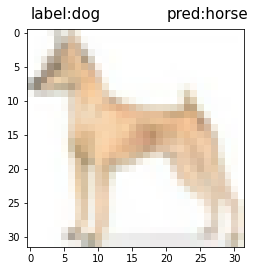

In [65]:
net.eval()
dataiter = iter(trainloader)
images, labels = next(dataiter)
idx = 0
img = torch.unsqueeze(images[idx], 0)
prediction = torch.argmax(net(img))
my_imshow(images[idx], classes[labels[idx]], classes[prediction])
